In [ ]:
from image_process import (
    threshold,
    morphology,
    find_contours,
    extra_contour_elimination,
    crop_contour,
    req_contour
)
import csv
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.models import load_model
model = load_model('model.hdf5')

In [ ]:
dest_dir = 'plot'
def plot(filename,file):
    img = cv2.imread(filename)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    clone = img.copy()
    thresh = threshold(img)
    img, lines = find_contours(thresh)
    final_lines = extra_contour_elimination(lines)
    req = []
    contour = []
    for i,line in enumerate(final_lines):
        L = crop_contour(line,thresh)
        img = cv2.resize(L,(28,28))
        data = img.reshape(1,28,28,1)
        model_out = model.predict([data])

        if np.argmax(model_out)==1:
            str_label = '0'
        else:
            str_label = '1'

        if str_label=='1':
            print(file)
            req.append(i)
            contour.append([file,line])
            name = dest_dir+'/'+file
#             print(name)
            

    for index in req:
        rect = cv2.minAreaRect(final_lines[index])
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(clone,[box],0,(0,255,0),2)
        cv2.imwrite(name,clone)

In [ ]:
orig_dir = 'CV-Assignment-Dataset'
for file in os.listdir(orig_dir):
    path = os.path.join(orig_dir,file)
    plot(path,file)

In [171]:
filename = 'data/train/1/18.jpeg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

[[13.848452  10.239368 ]
 [13.848895  10.239214 ]
 [ 2.1785715 22.607143 ]
 [25.928862  19.165775 ]
 [22.666443  25.453205 ]]
249


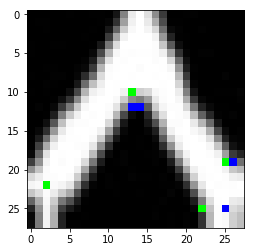

In [174]:
# find Harris corners
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.001*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

        
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(3,3),(-1,-1),criteria)
        

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

cv2.imwrite('subpixel5.png',img)
plt.imshow(img)
print(corners)
print(gray[10,9])

In [175]:
x = [p[0] for p in centroids]
y = [p[1] for p in centroids]
com = (sum(x) / len(centroids), sum(y) / len(centroids))
print(com)

(16.54025010597711, 18.266998728274693)


14 16


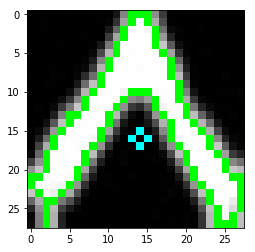

In [183]:
filename = 'data/train/1/18.jpeg'
image = cv2.imread(filename)
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 200, 255, 0, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
_, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

cnts = cv2.drawContours(image, contours[0], -1, (0, 255, 0), 1)

kpCnt = len(contours[0])

x = -10
y = -10

for kp in contours[0]:
    x = x+kp[0][0]
    y = y+kp[0][1]

cv2.circle(image, (np.uint8(np.ceil(x/kpCnt)), np.uint8(np.ceil(y/kpCnt))), 1, (0, 255, 255),1 )

print(np.uint8(np.ceil(x/kpCnt)),np.uint8(np.ceil(y/kpCnt)))
plt.imshow(cnts)
# cv2.namedWindow("Result", cv2.WINDOW_NORMAL)
# cv2.imshow("Result", cnts)
# cv2.waitKey(0)
# cv2.destroyAllWindows()